## Integration of Tasselled Cap Transformation for Detailed Land Cover Mapping

This script contain the learning and classification process of Multisource Remote Sensing data for Land Cover Land Use Mapping. The data is prepared in Earth Engine, and downloaded to be process in desktop machine. The training data is created using visual interpretation, assisted with Indonesia Topographical Map
<br>
This script is organized as follows:
1. Library Import and Pixel Extraction
2. Hyperparameter Optimization
3. Model Evaluation
4. Classification

**1. Importing the Library**

In [8]:
# Import Library yang dibutuhkan
import rasterio
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
from rasterio.features import shapes
from rasterio.mask import mask
import joblib
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, HistGradientBoostingClassifier
from sklearn.feature_selection import RFECV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score, log_loss
from imblearn.metrics import geometric_mean_score, classification_report_imbalanced
from sklearn.utils import compute_class_weight

**1.1 Importing the Raster and Training Data**

In [12]:
#importing the raster data
raster_file = 'C:\Master of Remote Sensing\Python Code\Github_Repo_TassCap_Project\Data Source\Landsat9_Final_Addtwi.tif'
dataset = rasterio.open(raster_file)  
# Bands Names
desc = dataset.descriptions
print('Raster description: {desc}\n'.format(desc=desc)) 
#inspecting the raste file. The format is bands,row, column
L9_MS = dataset.read()
#tranpose the data into the form of row, column, bands
L9_MS = L9_MS.transpose(1, 2, 0)
L9_MS.shape
#adding the training data
sample = gpd.read_file('C:\Master of Remote Sensing\Python Code\Github_Repo_TassCap_Project\Data Source\TrainingSamples_rev21.shp')
sample.head()
# Class sample counts
print(sample['CLASS_NAME'].value_counts())

Raster description: ('B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B10', 'elevation', 'slope', 'TPILF', 'aspect', 'FlowA', 'TWI', 'brightness', 'greenness', 'wetness', 'TCA', 'NDVI', 'BUI', 'MNDWI', 'EVI', 'AWEI')

CLASS_NAME
LP       121
SW        90
SI        52
PL        48
HLT       46
BP        45
PBK       31
SB        31
HB/PA     27
HPP       24
HLR       21
PT        21
HT        21
BPP       19
HR        19
TA        15
LTA       14
LTD       13
PS        11
KAA        8
HM         7
Name: count, dtype: int64


**1.2 Pixel Extraction Function**

In [9]:
#Pixel Extraction function
def extract_pixels_from_shapefile(shapefile, raster):
    training_samples = []
    for index, row in shapefile.iterrows():
        geometry = [row['geometry']]
        id_class = row['New_ID'] #Uniqe Land Cover ID
        # Raster Masking based on input training data
        out_image, out_transform = mask(raster, geometry, crop=True)
        # Reshaping Raster (bands, height, width) 
        out_image = out_image.reshape(raster.count, -1).T  
        # Removing invalid pixels
        valid_pixels = out_image[~np.isnan(out_image).any(axis=1)]
        # Adding valid pixels ID
        for pixel in valid_pixels:
            training_samples.append((pixel, id_class))
    # Converts the tuple list into numpy array
    features = np.array([sample[0] for sample in training_samples])  # Extract pixel values (features)
    labels = np.array([sample[1] for sample in training_samples])    # Extract class labels
    return features, labels

In [10]:
# Menggunakan funtion extract pixel values yang sudah dibuat untuk mendapatkan fatures dan label:
features, labels = extract_pixels_from_shapefile(sample, dataset)
# checking the shape of features and labels
print(features.shape)
print(labels.shape)
# masking nan values
nan_mask = np.isnan(features).any(axis=1) | np.isnan(labels)
features = features[~nan_mask]
labels = labels[~nan_mask]
# Counting each pixel samples
sample_new = pd.DataFrame({'class': labels})
print(sample_new['class'].value_counts())

(21665, 23)
(21665,)
class
13.0    4163
4.0     3476
17.0    2427
10.0    1925
14.0    1811
15.0    1614
3.0     1269
8.0     1206
0.0     1106
16.0     574
7.0      510
2.0      445
6.0      261
11.0     229
1.0      152
5.0      151
9.0      134
12.0     118
18.0      94
Name: count, dtype: int64


**1.3 Training and testing split**
1. The training data is used for model learning
2. The Testing data is used for model evaluation

In [ ]:
from sklearn.model_selection import train_test_split

# Split data: 70% for training and 30% for testing
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, stratify=labels, random_state=42)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

# Calculate the number of pixels for each class in the training set
unique_classes_train, class_counts_train = np.unique(y_train, return_counts=True)

# Calculate the number of pixels for each class in the testing set
unique_classes_test, class_counts_test = np.unique(y_test, return_counts=True)

# Combine into a single DataFrame for easier visualization
class_distribution = pd.DataFrame({
    'Class': np.union1d(unique_classes_train, unique_classes_test),
    'Pixel_Count_Train': [class_counts_train[unique_classes_train.tolist().index(cls)] if cls in unique_classes_train else 0 for cls in np.union1d(unique_classes_train, unique_classes_test)],
    'Pixel_Count_Test': [class_counts_test[unique_classes_test.tolist().index(cls)] if cls in unique_classes_test else 0 for cls in np.union1d(unique_classes_train, unique_classes_test)]
})

# Display the combined class distribution
print("Class Distribution (Training and Testing Sets):")
print(class_distribution)
#class_distribution.to_csv('C:\Master of Remote Sensing\Python Code\Tascap_Project\Region of Interest/train_test_L9.csv')

(15165, 23) (6500, 23) (15165,) (6500,)
Class Distribution (Training and Testing Sets):
    Class  Pixel_Count_Train  Pixel_Count_Test
0     0.0                774               332
1     1.0                106                46
2     2.0                311               134
3     3.0                888               381
4     4.0               2433              1043
5     5.0                106                45
6     6.0                183                78
7     7.0                357               153
8     8.0                844               362
9     9.0                 94                40
10   10.0               1347               578
11   11.0                160                69
12   12.0                 83                35
13   13.0               2914              1249
14   14.0               1268               543
15   15.0               1130               484
16   16.0                402               172
17   17.0               1699               728
18   18.0          

In [ ]:
#Optional, saving the training and testing data
np.save('C:/Master of Remote Sensing/Python Code/Tascap_Project/Region of Interest/Numpy TD/x_train_L9.npy', x_train)
np.save('C:/Master of Remote Sensing/Python Code/Tascap_Project/Region of Interest/Numpy TD/x_test_L9.npy', x_test)
np.save('C:/Master of Remote Sensing/Python Code/Tascap_Project/Region of Interest/Numpy TD/y_train_L9.npy', y_train)
np.save('C:/Master of Remote Sensing/Python Code/Tascap_Project/Region of Interest/Numpy TD/y_test_L9.npy', y_test)

**1.4 Scenario Definition**

For assessing the integration, several integration scenario is used:
1. Baseline (multispectral data only)
2. Scenario 1 (Multispectral data and Tasselled Cap Transformation)
3. Scenario 2 (Multispectral, Tasseled Cap, and Spectral Index)
4. Scenario 3 (Multispectral, Tasseled Cap, and Topographical Data)
4. Scenario 4 (All features is utilized)

In [ ]:
#defining the band name
band_name = [
    'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B10','elevation', 'slope','TPILF','aspect', 'FlowA', 'TWI', 'brightness', 'greenness', 'wetness',
    'TCA', 'NDVI','BUI', 'MNDWI', 'EVI', 'AWEI']
# Define feature groups by name
groups = {
    "Multispectral_only": ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B10'], #Baseline
    "Multispectral_TC": ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B10', 'brightness', 'greenness', 'wetness', 'TCA'], #Scenario 1
    "Multispectral_Topo_TC": ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B10', 'brightness', 'greenness', 'wetness', 'TCA',
                           'elevation', 'slope','TPILF','aspect', 'FlowA', 'TWI'], #Scenario 3
    "Multispectral_TC_Spec": ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B10', 'brightness', 'greenness', 'wetness', 'TCA', 'NDVI','BUI', 'MNDWI', 'EVI', 'AWEI'],#Scenario 2                      
    "All_Features": band_name  # Scenario 4
}
# Get indices for each group
group_indices = {}
for group_name, features in groups.items():
    indices = [band_name.index(band) for band in features]
    group_indices[group_name] = indices
# Example: Subset for "Multispectral_only"
group = "Multispectral_only"
x_train_ms = x_train[:, group_indices[group]]
x_test_ms = x_test[:, group_indices[group]]

print(f"Shape of {group} features - Train: {x_train_ms.shape}, Test: {x_test_ms.shape}")

Shape of Multispectral_only features - Train: (15165, 8), Test: (6500, 8)


Split the training data features based on scenarios:

In [8]:
# Example: Subset for "Multispectral_only"
group = "Multispectral_only"
x_train_ms = x_train[:, group_indices[group]]
x_test_ms = x_test[:, group_indices[group]]

print(f"Shape of {group} features - Train: {x_train_ms.shape}, Test: {x_test_ms.shape}")

Shape of Multispectral_only features - Train: (15165, 8), Test: (6500, 8)


In [9]:
# Example: Subset for "Multispectral_TC"
group = "Multispectral_Topo_TC"
x_train_topo = x_train[:, group_indices[group]]
x_test_topo = x_test[:, group_indices[group]]

print(f"Shape of {group} features - Train: {x_train_topo.shape}, Test: {x_test_topo.shape}")

Shape of Multispectral_Topo_TC features - Train: (15165, 18), Test: (6500, 18)


In [10]:
# Example: Subset for "Multispectral_TC_Topo"
group = "Multispectral_TC"
x_train_tc = x_train[:, group_indices[group]]
x_test_tc = x_test[:, group_indices[group]]

print(f"Shape of {group} features - Train: {x_train_tc.shape}, Test: {x_test_tc.shape}")

Shape of Multispectral_TC features - Train: (15165, 12), Test: (6500, 12)


In [11]:
# Example: Subset for "Multispectral_TC_Topo"
group = "Multispectral_TC_Spec"
x_train_spec = x_train[:, group_indices[group]]
x_test_spec = x_test[:, group_indices[group]]

print(f"Shape of {group} features - Train: {x_train_spec.shape}, Test: {x_test_spec.shape}")

Shape of Multispectral_TC_Spec features - Train: (15165, 17), Test: (6500, 17)


**2 Parameter Space Definition and Hyperparameter Tuning/Optimization**

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
xgb_param_grid = {
    'n_estimators': [300, 500, 700, 900, 1100],
    'max_depth': [3, 6, 15, 20, 30],
    'min_child_weight': [1, 3, 9, 13],
    'learning_rate': [0.001, 0.01, 0.1, 0.2],
    'subsample': [0.1, 0.5, 1.0],
    'colsample_bytree': [0.1, 0.5, 1.0]    
}
xgb_model = XGBClassifier(objective='multi:softprob', num_class = 18, eval_metric = 'mlogloss', random_state=42)

Fitting 11 folds for each of 20 candidates, totalling 220 fits
Fitting 11 folds for each of 20 candidates, totalling 220 fits
Fitting 11 folds for each of 20 candidates, totalling 220 fits
Fitting 11 folds for each of 20 candidates, totalling 220 fits
Fitting 11 folds for each of 20 candidates, totalling 220 fits
                    Classifier  Best Accuracy  \
0                      MS only       0.686184   
1                      TC only       0.689020   
2  With Topographical Features       0.710714   
3                All  Features       0.711242   
4           Spectral  Features       0.686646   

                                         Best Params  Log Loss  Tuning Time  
0  {'subsample': 0.5, 'n_estimators': 700, 'min_c...  0.940685   848.080142  
1  {'subsample': 0.5, 'n_estimators': 1100, 'min_...  0.946144  1050.893809  
2  {'subsample': 1.0, 'n_estimators': 500, 'min_c...  0.854587  1188.748429  
3  {'subsample': 1.0, 'n_estimators': 700, 'min_c...  0.851036   836.861797  


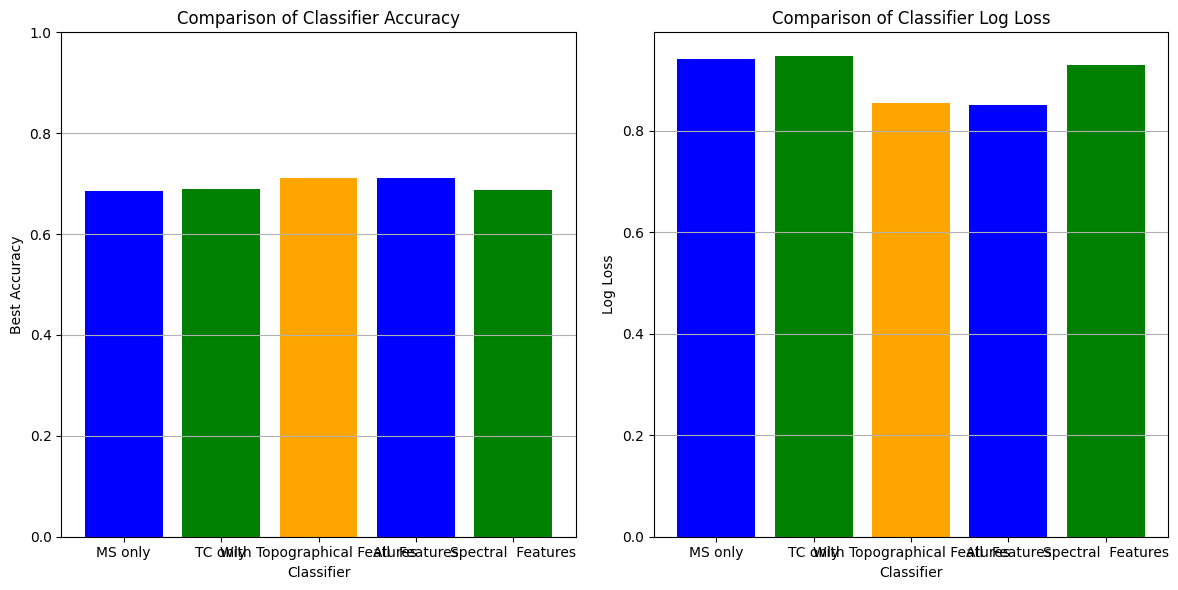

In [13]:
import time
# Initialize a list to store results
results = []

# Randomized Search with Cross Validation for XGB
ms_time = time.time()
xgb_ms = RandomizedSearchCV(xgb_model, xgb_param_grid, n_iter=20,  cv=11, scoring='accuracy', n_jobs=-1,verbose=3,return_train_score=True
)
xgb_ms.fit(x_train_ms, y_train)
ms_end = time.time()
time_ms = ms_end - ms_time
# Compute log loss for XGB
best_ms = xgb_ms.best_estimator_
ms_prob = best_ms.predict_proba(x_test_ms)
xgb_log_loss = log_loss(y_test, ms_prob)
results.append({
    'Classifier': 'MS only',
    'Best Accuracy': xgb_ms.best_score_,
    'Best Params': xgb_ms.best_params_,
    'Log Loss': xgb_log_loss,
    'Tuning Time': time_ms
})

start_tc = time.time()
tc_rcv = RandomizedSearchCV(xgb_model, xgb_param_grid, n_iter=20,  cv=11, scoring='accuracy', n_jobs=-1,verbose=3,return_train_score=True
)
tc_rcv.fit(x_train_tc, y_train)
end_tc = time.time()
time_tc = end_tc - start_tc
# Compute log loss for RF
best_tc = tc_rcv.best_estimator_
tc_prob = best_tc.predict_proba(x_test_tc)
tc_log_loss = log_loss(y_test, tc_prob)
results.append({
    'Classifier': 'TC only',
    'Best Accuracy': tc_rcv.best_score_,
    'Best Params': tc_rcv.best_params_,
    'Log Loss': tc_log_loss,
    'Tuning Time': time_tc
})

# Randomized Search with Cross Validation for LightGBM
start_topo = time.time()
topo_rcv = RandomizedSearchCV(xgb_model, xgb_param_grid, n_iter=20,  cv=11, scoring='accuracy', n_jobs=-1,verbose=3,return_train_score=True
)
topo_rcv.fit(x_train_topo, y_train)
end_topo = time.time()
topo_time = end_topo - start_topo

# Compute log loss for LGBM
best_topo = topo_rcv.best_estimator_
topo_prob = best_topo.predict_proba(x_test_topo)
topo_log_loss = log_loss(y_test, topo_prob)
results.append({
    'Classifier': 'With Topographical Features',
    'Best Accuracy': topo_rcv.best_score_,
    'Best Params': topo_rcv.best_params_,
    'Log Loss': topo_log_loss,
    'Tuning Time': topo_time
})

start_all = time.time()
all_rcv = RandomizedSearchCV(xgb_model, xgb_param_grid, n_iter=20,  cv=11, scoring='accuracy', n_jobs=-1,verbose=3,return_train_score=True
)
all_rcv.fit(x_train, y_train)
end_all = time.time()
all_time = end_all - start_all
best_all = all_rcv.best_estimator_
all_prob = best_all.predict_proba(x_test)
all_logloss = log_loss(y_test, all_prob)
results.append({
    'Classifier': 'All  Features',
    'Best Accuracy': all_rcv.best_score_,
    'Best Params': all_rcv.best_params_,
    'Log Loss': all_logloss,
    'Tuning Time': all_time
})
# Randomized Search with Cross Validation for XGB
spec_start = time.time()
xgb_spec = RandomizedSearchCV(xgb_model, xgb_param_grid, n_iter=20,  cv=11, scoring='accuracy', n_jobs=-1,verbose=3,return_train_score=True
)
xgb_spec.fit(x_train_spec, y_train)
spec_end = time.time()
time_spec = spec_start - spec_end
best_spec = xgb_spec.best_estimator_
spec_prob = best_spec.predict_proba(x_test_spec)
spec_logloss = log_loss(y_test, spec_prob)
results.append({
    'Classifier': 'Spectral  Features',
    'Best Accuracy': xgb_spec.best_score_,
    'Best Params': xgb_spec.best_params_,
    'Log Loss': spec_logloss,
    'Tuning Time': time_spec
})

# Convert results to a pandas DataFrame
results_df = pd.DataFrame(results)

# Print the DataFrame
print(results_df)
results_df.to_csv('C:\Master of Remote Sensing\Python Code\Tascap_Project/CV_XGB_old.csv')
# Visualize results
plt.figure(figsize=(12, 6))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.bar(results_df['Classifier'], results_df['Best Accuracy'], color=['blue', 'green', 'orange'])
plt.xlabel('Classifier')
plt.ylabel('Best Accuracy')
plt.title('Comparison of Classifier Accuracy')
plt.ylim(0, 1)
plt.grid(axis='y')

# Plot Log Loss
plt.subplot(1, 2, 2)
plt.bar(results_df['Classifier'], results_df['Log Loss'], color=['blue', 'green', 'orange'])
plt.xlabel('Classifier')
plt.ylabel('Log Loss')
plt.title('Comparison of Classifier Log Loss')
plt.grid(axis='y')

plt.tight_layout()
plt.show()

Saving the best model

In [14]:
joblib.dump(best_ms, 'C:\Master of Remote Sensing\Python Code\Tascap_Project\Trained Model\Best_ms_old.pkl', compress=('zlib', 3))
joblib.dump(best_tc, 'C:\Master of Remote Sensing\Python Code\Tascap_Project\Trained Model\Best_tc_old.pkl', compress=('zlib', 3))
joblib.dump(best_topo, 'C:\Master of Remote Sensing\Python Code\Tascap_Project\Trained Model\Best_topo_old.pkl', compress=('zlib', 3))
joblib.dump(best_all, 'C:\Master of Remote Sensing\Python Code\Tascap_Project\Trained Model\Best_all_old.pkl', compress=('zlib', 3))
joblib.dump(best_spec, 'C:\Master of Remote Sensing\Python Code\Tascap_Project\Trained Model\Best_spec_old.pkl', compress=('zlib', 3))

['C:\\Master of Remote Sensing\\Python Code\\Tascap_Project\\Trained Model\\Best_spec_old.pkl']

**3. Model Evaluation**

Since the data is imbalance, several metrics is used to assess the model:
1. Overall Accuracy
2. Cross Entropy Loss (CE)
3. F1 Score
4. Geometric Mean (Gmean)

For CE Loss, F1, and Gmean, calculation is conducted while utilizing the class weight of each class

In [ ]:
# Classifiers and corresponding transformed test data
best_ms = joblib.load('C:\Master of Remote Sensing\Python Code\Tascap_Project\Trained Model\Best_ms_old.pkl')
best_tc = joblib.load('C:\Master of Remote Sensing\Python Code\Tascap_Project\Trained Model\Best_tc_old.pkl')
best_topo = joblib.load('C:\Master of Remote Sensing\Python Code\Tascap_Project\Trained Model\Best_topo_old.pkl')
best_spec = joblib.load('C:\Master of Remote Sensing\Python Code\Tascap_Project\Trained Model\Best_spec_old.pkl')
best_all = joblib.load('C:\Master of Remote Sensing\Python Code\Tascap_Project\Trained Model\Best_all_old.pkl')

classifiers = {
    'Multispectral Only': {'model': best_ms, 'x_train': x_train_ms, 'x_test': x_test_ms},
    'Multispectral and TC': {'model': best_tc, 'x_train': x_train_tc, 'x_test': x_test_tc},
    'Multispectral TC and Topographical data': {'model': best_topo, 'x_train': x_train_topo, 'x_test': x_test_topo},
    'Multispectral TC and Spectral data': {'model': best_spec, 'x_train': x_train_spec, 'x_test': x_test_spec},
    'All features': {'model': best_all, 'x_train': x_train, 'x_test': x_test},
}

# Store results
individual_accuracies = []

# Calculate class weights and evaluate classifiers
for name, clf_data in classifiers.items():
    clf = clf_data['model']
    x_train = clf_data['x_train']
    x_test = clf_data['x_test']

    # Calculate class weights based on RFECV-reduced training data
    unique_classes = np.unique(y_train)  # Assuming y_train is the same for all classifiers
    weights = compute_class_weight(
        class_weight='balanced',
        classes=unique_classes,
        y=y_train
    )
    class_weight_dict = dict(zip(unique_classes, weights))
    print(f"Class weights for {name}: {class_weight_dict}")

    # Predict using the current classifier
    y_pred = clf.predict(x_test)
    y_pred_proba = clf.predict_proba(x_test)

    # Calculate metrics
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted', sample_weight=[class_weight_dict[cls] for cls in y_test])
    w_logloss = log_loss(y_test, y_pred_proba, sample_weight=[class_weight_dict[cls] for cls in y_test])
    gmean = geometric_mean_score(y_test, y_pred, average='weighted', sample_weight=[class_weight_dict[cls] for cls in y_test])

    # Append results
    individual_accuracies.append((name, acc, f1, w_logloss, gmean))
    print(f'Accuracy of {name}: {acc:.4f}')
    print(f'F1 Score of {name}: {f1:.4f}')
    print(f'Log loss of {name}: {w_logloss:.4f}')
    print(f'Geometric Mean of {name}: {gmean:.4f}')

# Identify the worst-performing classifier
worst_classifier = min(individual_accuracies, key=lambda x: x[1])
print(f'\nWorst-performing classifier: {worst_classifier[0]} with accuracy: {worst_classifier[1]:.4f}')
print(f'F1 Score of worst-performing classifier: {worst_classifier[2]:.4f}')

# Convert results to DataFrame for easier visualization
columns = ['Classifier', 'Overall Accuracy', 'F1 Score', 'Log Loss', 'Geometric Mean']
result_df = pd.DataFrame(individual_accuracies, columns=columns)

# Save the DataFrame
result_df.to_csv('C:\Master of Remote Sensing\Python Code\Tascap_Project\Results_x_analyisi\Scenarios_accuracy_L9_final.csv', index=False)
print(result_df)

Class weights for Multispectral Only: {0.0: 1.0312117503059977, 1.0: 7.52979145978153, 2.0: 2.56642409883229, 3.0: 0.8988264580369844, 4.0: 0.3280550327730547, 5.0: 7.52979145978153, 6.0: 4.361518550474547, 7.0: 2.2357363998230873, 8.0: 0.9456847094038413, 9.0: 8.491041433370661, 10.0: 0.5925448364787247, 11.0: 4.988486842105263, 12.0: 9.616360177552314, 13.0: 0.2739045623667955, 14.0: 0.6294620620953013, 15.0: 0.7063344201210993, 16.0: 1.985467399842891, 17.0: 0.46978098571915367, 18.0: 12.0933014354067}
Accuracy of Multispectral Only: 0.6931
F1 Score of Multispectral Only: 0.6789
Log loss of Multispectral Only: 1.4113
Geometric Mean of Multispectral Only: 0.7766
Class weights for Multispectral and TC: {0.0: 1.0312117503059977, 1.0: 7.52979145978153, 2.0: 2.56642409883229, 3.0: 0.8988264580369844, 4.0: 0.3280550327730547, 5.0: 7.52979145978153, 6.0: 4.361518550474547, 7.0: 2.2357363998230873, 8.0: 0.9456847094038413, 9.0: 8.491041433370661, 10.0: 0.5925448364787247, 11.0: 4.9884868421

**4 Classification and Saving the LULC Maps**

In [17]:
# Define feature groups by name
groups = {
    "Multispectral_only": ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B10'],
    "Multispectral_TC": ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B10', 'brightness', 'greenness', 'wetness', 'TCA'],
    "Multispectral_Topo_TC": ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B10', 'brightness', 'greenness', 'wetness', 'TCA',
                           'elevation', 'slope','TPILF','aspect', 'FlowA', 'TWI'],
    "Multispectral_TC_Spec": ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B10', 'brightness', 'greenness', 'wetness', 'TCA', 
                              'NDVI','BUI', 'MNDWI', 'EVI', 'AWEI'],                      
                            
    "All_Features": band_name  # Everything
}
# Get indices for each group
group_indices = {}
for group_name, features in groups.items():
    indices = [band_name.index(band) for band in features]
    group_indices[group_name] = indices

def classify_raster_by_scenario(raster, model, scenario_name):
   
    # Get band indices for this scenario
    band_idx = group_indices[scenario_name]
    
    # Read selected bands from raster
    raster_data = raster.read()  # Shape: (bands, height, width)
    selected_data = raster_data[band_idx, :, :]
    
    # Reshape for classification
    height, width = raster.height, raster.width
    reshaped_data = selected_data.reshape(len(band_idx), -1).T  # (pixels, features)
    
    # Handle NaN values
    mask = np.isnan(reshaped_data).any(axis=1)
    classified = np.full(reshaped_data.shape[0], -1, dtype=int)  # -1 for NoData
    
    # Predict only on valid pixels
    if np.any(~mask):
        classified[~mask] = model.predict(reshaped_data[~mask])
    
    return classified.reshape((height, width))

def save_classified_raster(output_path, reference_raster, classified_data):
    """Save classified raster to GeoTIFF"""
    with rasterio.open(
        output_path,
        'w',
        driver='GTiff',
        height=reference_raster.height,
        width=reference_raster.width,
        count=1,
        dtype=classified_data.dtype,
        crs=reference_raster.crs,
        transform=reference_raster.transform,
    ) as dst:
        dst.write(classified_data, 1)
# Process all scenarios for each classifier


In [18]:
# Define which model to use for each scenario
scenario_models = {
    "Multispectral_only": best_ms,      # 8-band model
    "Multispectral_TC": best_tc,       # 12-band model
    "Multispectral_Topo_TC": best_topo,  # 12+ bands (but best_tc only uses 12)
    "All_Features": best_all,           # Model trained on all bands (if available)
    'Multispectral_TC_Spec': best_spec
}

for scenario_name in group_indices.keys():
    print(f"\nProcessing scenario: {scenario_name}")
    
    # Get the right model for this scenario
    model = scenario_models[scenario_name]
    
    # Classify and save
    classified_map = classify_raster_by_scenario(dataset, model, scenario_name)
    save_classified_raster(f'New_LULCL9_{scenario_name}.tif', dataset, classified_map)


Processing scenario: Multispectral_only

Processing scenario: Multispectral_TC

Processing scenario: Multispectral_Topo_TC

Processing scenario: Multispectral_TC_Spec

Processing scenario: All_Features


**LULC Visualization**

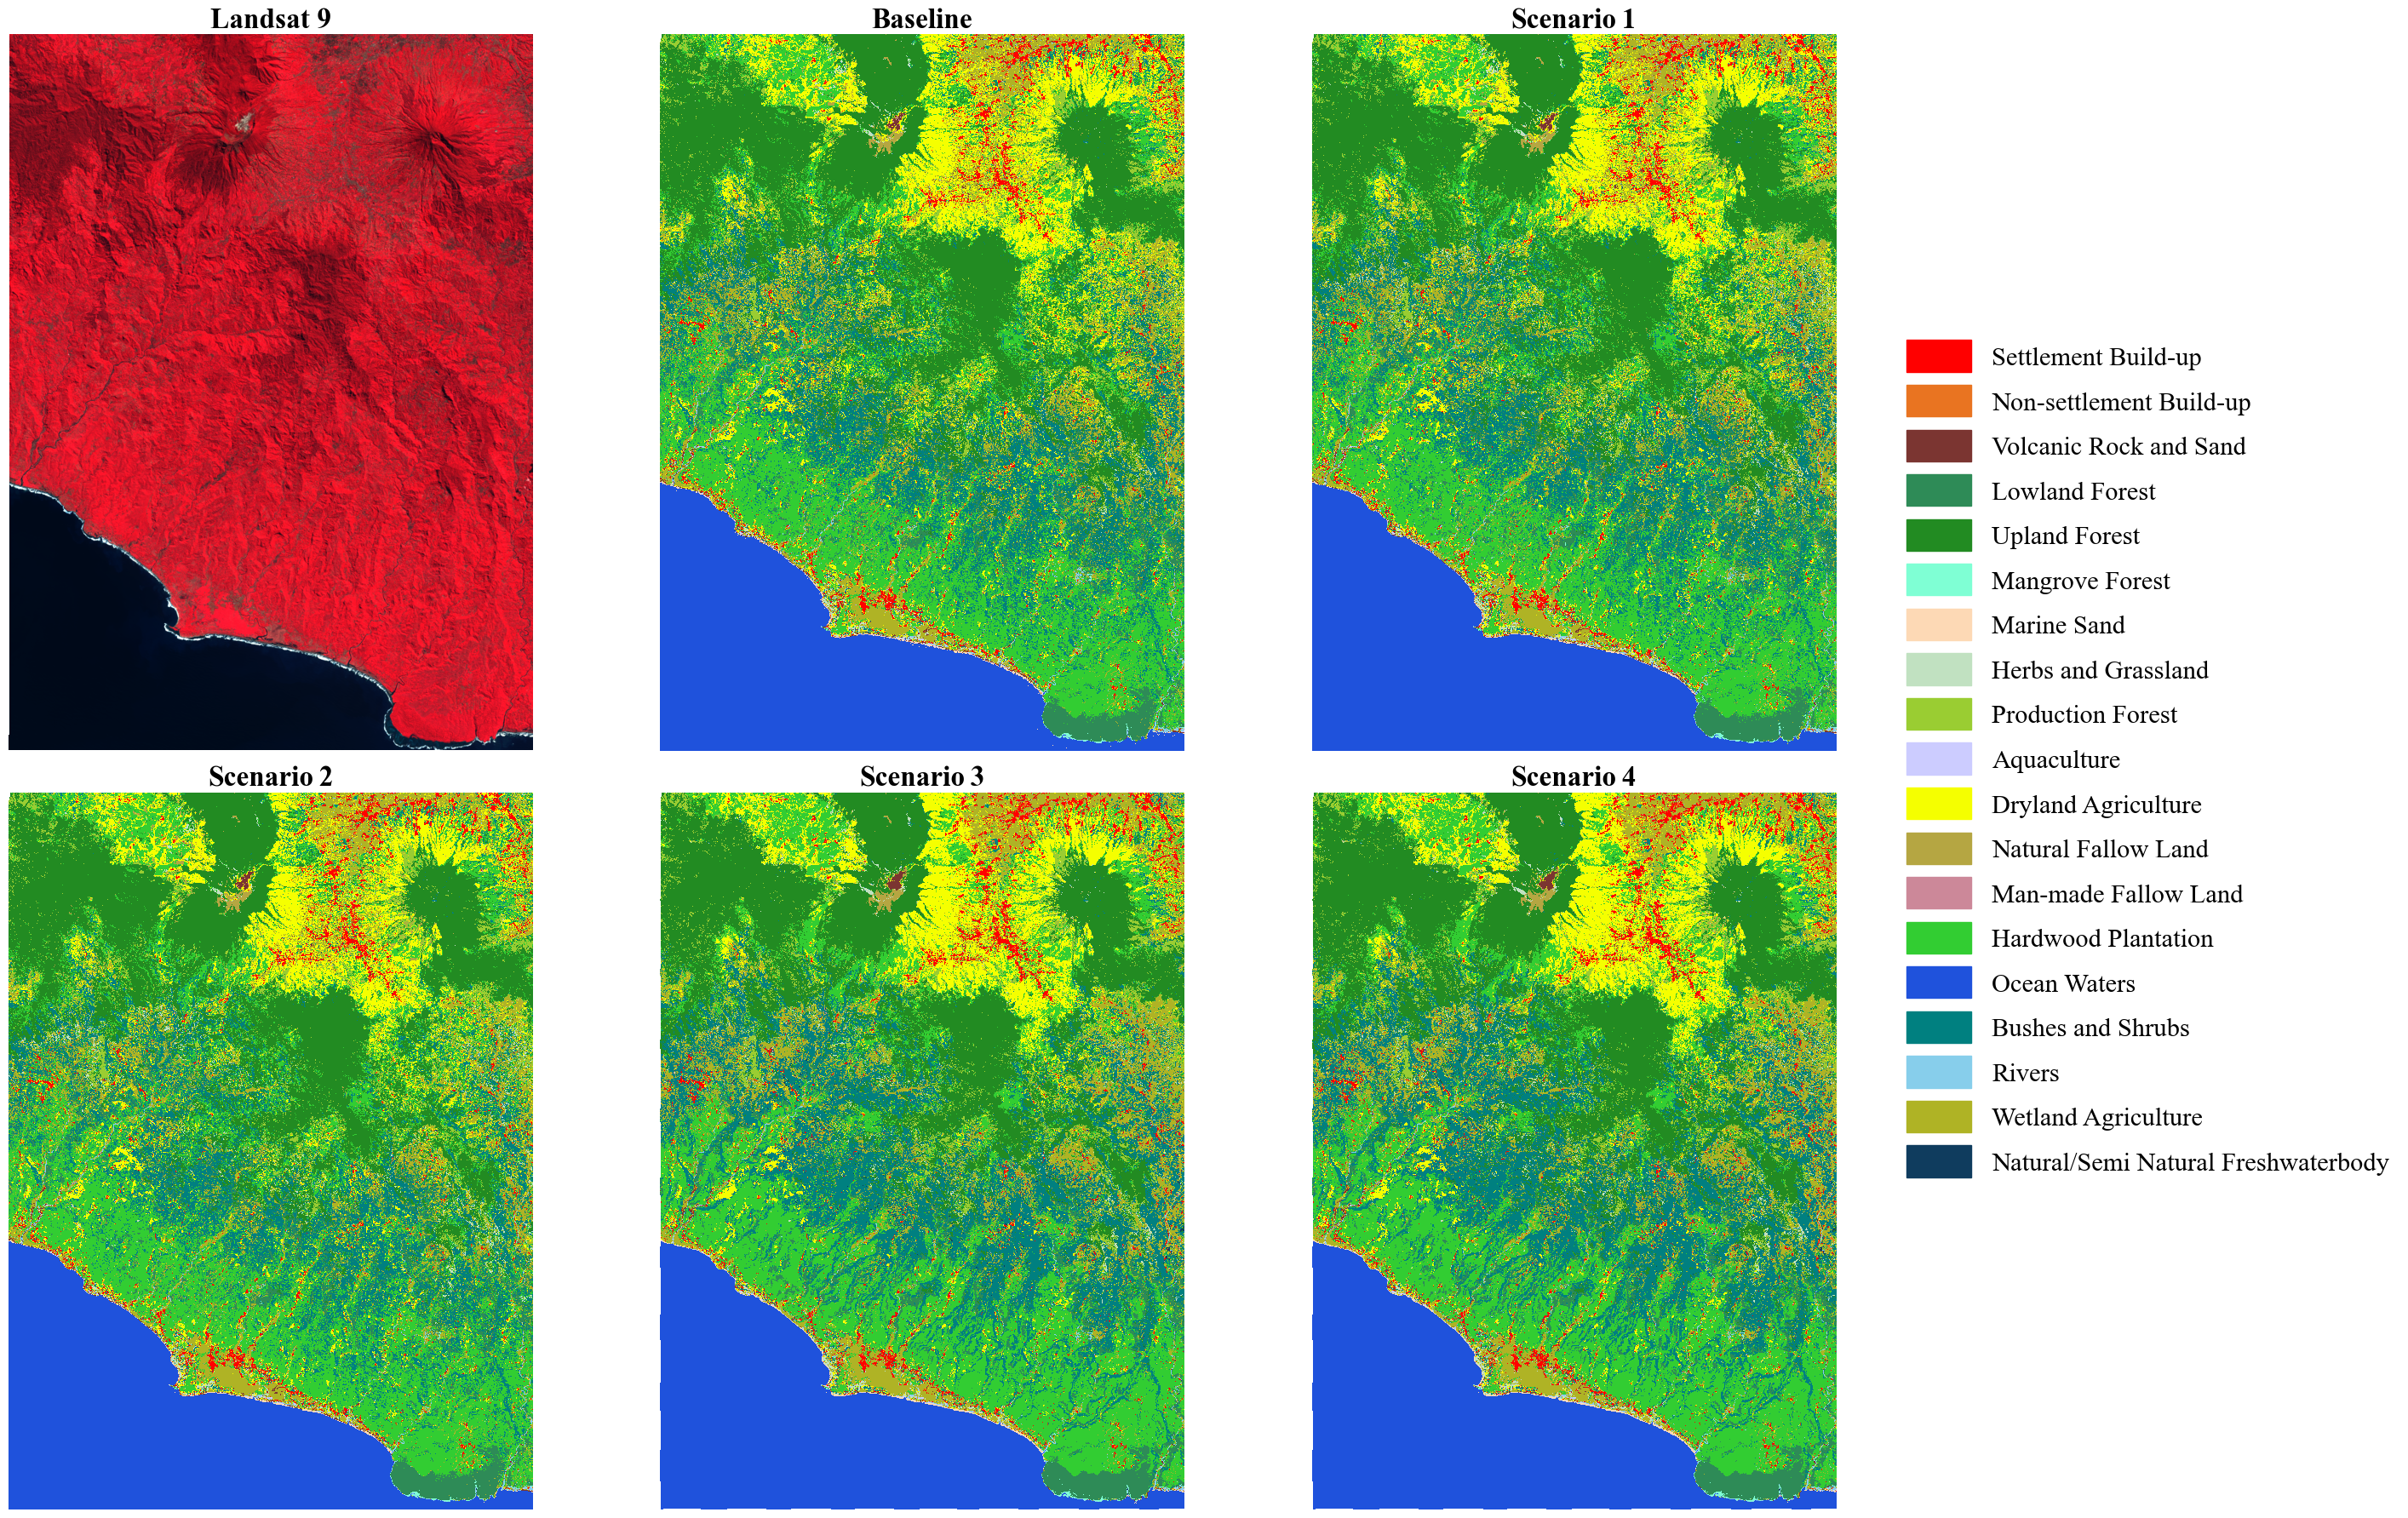

In [50]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap, BoundaryNorm
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
from matplotlib.offsetbox import AnchoredText
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# 1. Define legend and colors for classes
legend_21 = ['Settlement Build-up', 'Non-settlement Build-up', 'Volcanic Rock and Sand', 'Lowland Forest', 
             'Upland Forest', 'Mangrove Forest', 'Marine Sand', 'Herbs and Grassland', 'Production Forest', 
             'Aquaculture', 'Dryland Agriculture', 'Natural Fallow Land', 'Man-made Fallow Land', 'Hardwood Plantation',
             'Ocean Waters', 'Bushes and Shrubs', 'Rivers', 'Wetland Agriculture',
             'Natural/Semi Natural Freshwaterbody']

legend_colors = ['#FF0000', '#e97421', '#7b3531', '#2e8b57', '#228b22', '#7fffd4', '#fdd9b5', 
                 '#c1e1c1', '#9acd32', '#ccccff', '#f5ff00', '#b5a642', '#cc8899', '#32cd32', 
                  '#1f52dc', '#008080', '#87ceeb', '#afb325', '#0f3c5e']
#2. define the Original Raster data, and LULC data
rasters = {
    'Landsat 9': r'C:\Master of Remote Sensing\Python Code\Github_Repo_TassCap_Project\Data Source\Landsat9_Final_Addtwi.tif',
    "Baseline":   r"C:\Master of Remote Sensing\Python Code\Github_Repo_TassCap_Project\Output Land Cover Land Use\New_LULCL9_Multispectral_only.tif",
    "Scenario 1": r"C:\Master of Remote Sensing\Python Code\Github_Repo_TassCap_Project\Output Land Cover Land Use\New_LULCL9_Multispectral_TC.tif",
    "Scenario 2": r"C:\Master of Remote Sensing\Python Code\Github_Repo_TassCap_Project\Output Land Cover Land Use\New_LULCL9_Multispectral_TC_Spec.tif",
    "Scenario 3": r"C:\Master of Remote Sensing\Python Code\Github_Repo_TassCap_Project\Output Land Cover Land Use\New_LULCL9_Multispectral_Topo_TC.tif",
    "Scenario 4": r"C:\Master of Remote Sensing\Python Code\Github_Repo_TassCap_Project\Output Land Cover Land Use\New_LULCL9_All_Features.tif"
}
cmap  = ListedColormap(legend_colors, name="lulc21") # Build a discrete Colormap from the predefined hex color code
bounds = np.arange(len(legend_colors)+1) - 0.5       #Bound the pixel values, with no gradient or shades
norm   = BoundaryNorm(bounds, cmap.N) #Asigning one color one id

# 3.  Creating Layout Plot
mpl.rcParams.update({
    'font.family'     : 'Times New Roman',
})
n_maps = len(rasters) #Images that will be plot
n_rows = 2 #number of row 
n_cols = int(np.ceil(n_maps / n_rows)) # minimum cols to fit everything

fig, axes = plt.subplots(n_rows, n_cols, figsize=(8*n_cols, 9*n_rows), #Canvas size in inches
                         sharex=True, sharey=True)
axes = axes.ravel() #Flatten the 2D Numpy Array for easier looping

# 4.  Create a loop through each raster

for ax, (title, path) in zip(axes, rasters.items()):
    with rasterio.open(path) as src:
        if src.count > 1 and title.startswith("Landsat"):   # multiband FCC
            # --- READ BANDS 5,4,3 (1‑based) ---
            nir  = src.read(5).astype("float32")
            red  = src.read(4).astype("float32")
            green= src.read(3).astype("float32")
            rgb  = np.stack([nir, red, green], axis=-1)

            # --- SIMPLE PERCENTILE STRETCH (2‑98%) ---
            p2, p98 = np.percentile(rgb[~np.isnan(rgb)], (2, 98))
            rgb = np.clip((rgb - p2) / (p98 - p2), 0, 1)

            ax.imshow(rgb)
        else:                                              # categorical LULC
            data = src.read(1)
            nodata_vals = {src.nodata, -1}
            nodata_vals = {v for v in nodata_vals if v is not None}
            mask = np.isin(data, list(nodata_vals))
            data = np.where(mask, np.nan, data)
            ax.imshow(data, cmap=cmap, norm=norm, interpolation="nearest")

    ax.set_title(title,fontsize=24, fontweight= 'bold')
    ax.axis('off')

# hide any empty subplot (there will be one in a 2×3 grid)
for extra_ax in axes[n_maps:]:
    extra_ax.axis('off')

# 5.  Adding Legend for LULC Map
handles = [mpatches.Patch(color=c, label=lab)
           for lab, c in zip(legend_21, legend_colors)]

fig.legend(
    handles=handles,
    loc='center left', bbox_to_anchor=(0.97, 0.5),
    ncol=1,
    fontsize=22,
    frameon=False,
    handlelength=2.5,
    handleheight=1.5
)
plt.tight_layout(pad=1)
plt.show()